In [1]:
import warnings 
from math import pi
from itertools import batched
import pennylane as qml
import pennylane.numpy as np
from pennylane import AdamOptimizer
from qiskit.visualization import plot_histogram
from data import labels,relations,encode_angle,bit_string_parts_index_relations,starting_point
from tqdm import trange
  
  
warnings.filterwarnings('ignore') 

![graph](./assets/graph.png)

In [2]:
farest_distance = max(list(relations.values()))
print(f"Farest Distance: {farest_distance}")

Farest Distance: 9.8


In [3]:
n_qubits = len(list(relations.values())) - len(labels)
dev = qml.device('qiskit.aer', wires=n_qubits, shots=1)

In [13]:
@qml.qnode(dev)
def model(points, weights):
    qubit_index = 0
    for key,distance in points.items():
        if(distance==0):
            continue

        angle = encode_angle(distance, farest_distance)
        qml.RY(angle, wires=qubit_index)

        if(key[0] == starting_point):
            qml.RX(weights[qubit_index], wires=qubit_index)
            
        qubit_index += 1
    
    
    return qml.counts()

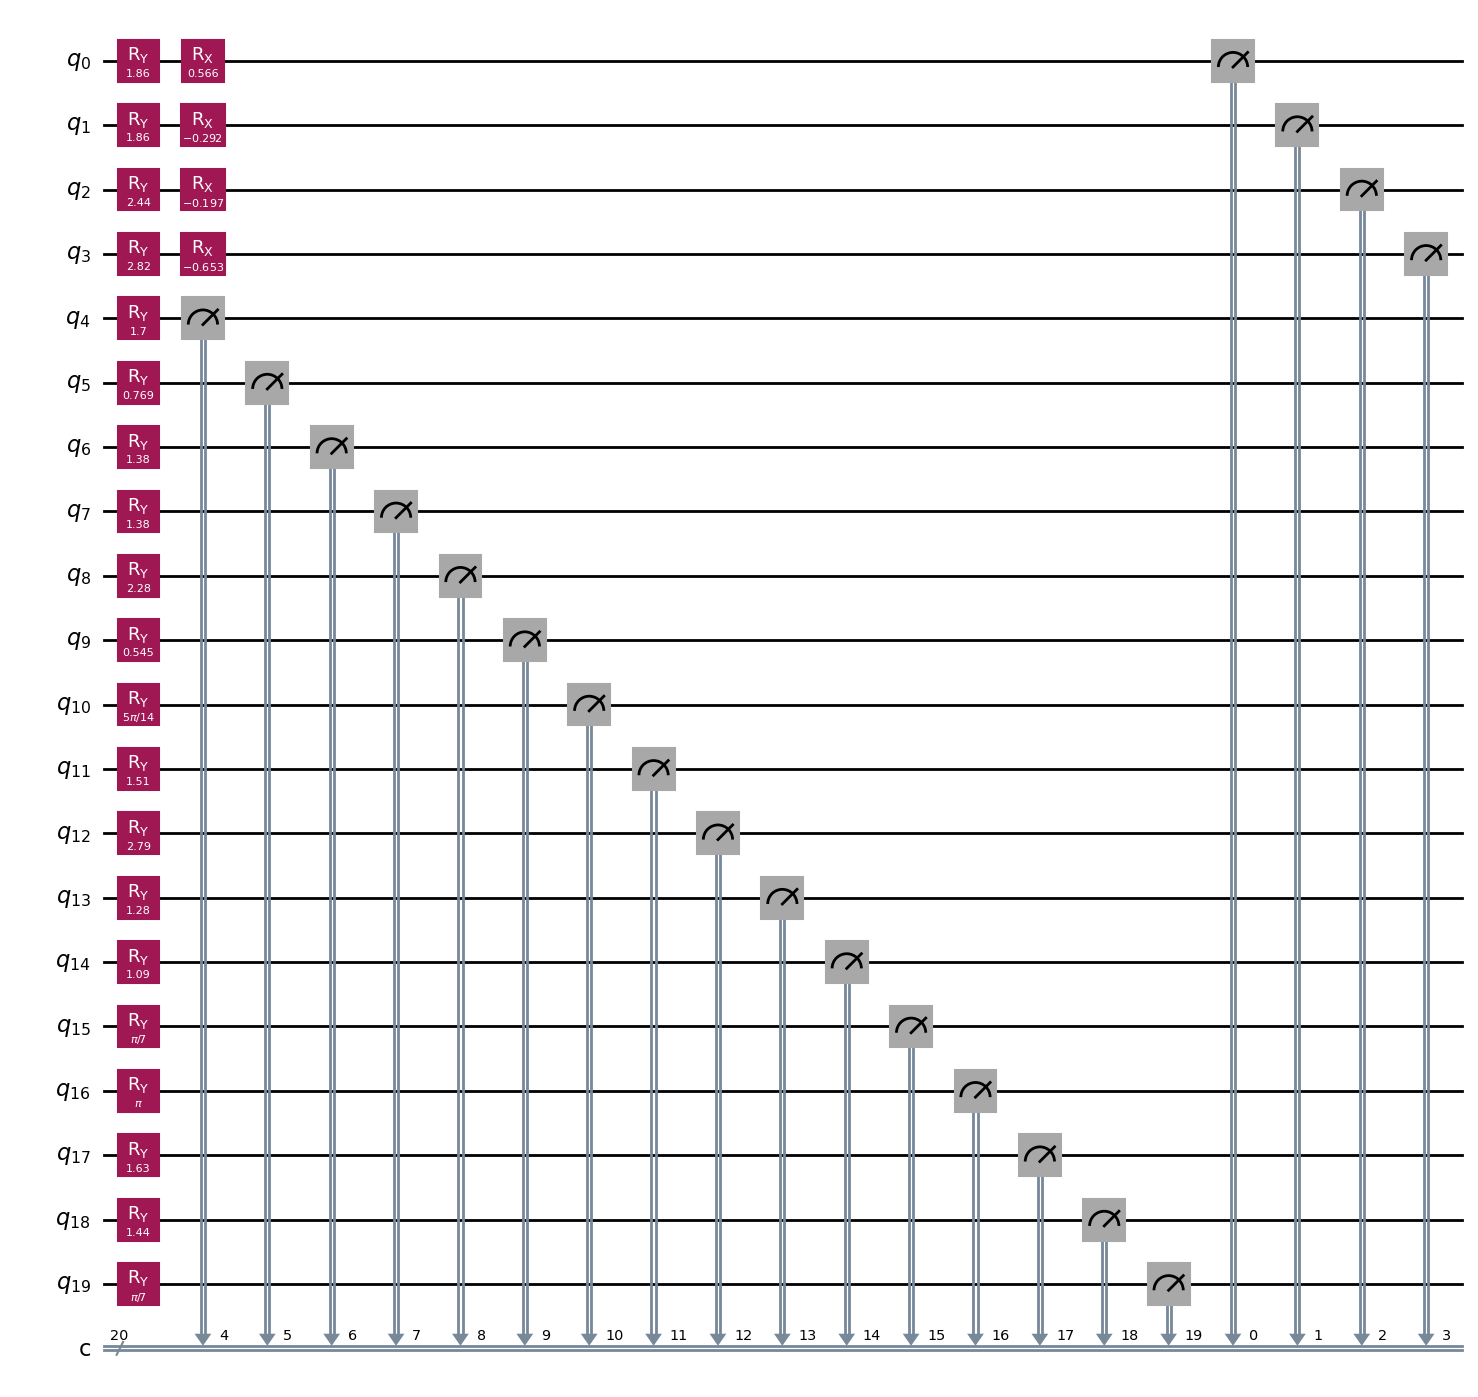

In [14]:
weights = np.random.uniform(-pi/2, pi/2, size=(n_qubits), requires_grad=True)
model(relations,weights)
dev._circuit.draw('mpl')

In [6]:
def get_string_score(bit_string,  P=100000.0):
    batches = list(batched(bit_string[::-1],4))
    concate = lambda x: ''.join(x)
    bit_string_parts = list(map(concate, batches)) 

    has_more_than_one_value_one = lambda x: x.count('1') > 1
    invalid_ones_count = list(map(has_more_than_one_value_one, bit_string_parts))

    if(any(invalid_ones_count)): # more than 1 value 1, so returns the penality 
        return P

    visited_nodes = ['A']
    current_part = 0
    path_total = 0
    path_count = 0


    while path_count < 4:
        part = bit_string_parts[current_part] 
        one_index = part.index('1')

        current_node = list(labels)[current_part]
        next_node = bit_string_parts_index_relations[current_part][one_index]

        path_total += relations[f'{current_node}{next_node}']
        path_count += 1

        current_part = list(labels).index(next_node)
        visited_nodes.append(next_node)
    
    if(len(visited_nodes) != len(set(visited_nodes))): # repeated nodes
        return P

    return path_total

In [7]:
def objective_fn(weights):
    result = model(relations, weights)
    bit_string = list(result[0].keys())[0].astype(str)
    score = get_string_score(bit_string)
    return score

In [8]:
STEPS = 1000

opt = AdamOptimizer()
for step in trange(STEPS):
    weights = opt.step(objective_fn, weights)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [06:08<00:00,  2.72it/s]


In [12]:
weights.tofile('qubo-inspired-weights')

In [13]:
model(relations, weights)

array([{np.str_('11101001110010100011'): np.int64(1)}], dtype=object)